**Dataset Preparation**
Data Acquisition: Download the specified datasets, which include 117,985 generated audio clips from Zenodo, along with the LJSPEECH and synthetically-created datasets for reference data. Also consider LibriTTS, Mozilla Common voice, VCTK dataset for human audio. Google's Tacotron 2 text-to-speech (TTS) samples can serve as an excellent source of synthetic speech, offering high-quality, diverse synthetic voices. Facebook's FAIR's WAV2VEC samples can also provide challenging, high-quality, synthetic speech examples for your classifier.


In [5]:
import os
import requests
from tqdm.auto import tqdm
from pathlib import Path
import tarfile
import numpy as np
import librosa
from scipy.fftpack import dct
from sklearn.mixture import GaussianMixture
from sklearn.metrics import classification_report, roc_curve
from sklearn.model_selection import train_test_split

def download_and_extract_dataset(url, extract_to):
    extract_to = Path(extract_to)
    if not extract_to.exists():
        extract_to.mkdir(parents=True)
    tar_path = extract_to / Path(url.split('/')[-1])
    if not tar_path.exists():
        try:
            response = requests.get(url, stream=True)
            total_size_in_bytes = int(response.headers.get('content-length', 0))
            progress_bar = tqdm(total=total_size_in_bytes, unit='iB', unit_scale=True)
            with open(tar_path, 'wb') as file:
                for data in response.iter_content(1024):
                    progress_bar.update(len(data))
                    file.write(data)
            progress_bar.close()
        except requests.RequestException as e:
            print(f"Error downloading {url}: {e}")
            return
    try:
        with tarfile.open(tar_path, "r:bz2") as tar:
            tar.extractall(path=extract_to)
    except tarfile.TarError as e:
        print(f"Error extracting {tar_path}: {e}")


In [ ]:
audios = audios[:100]

In [16]:
from python_speech_features import sigproc
from scipy.fftpack import dct

def compute_mel_filterbanks(signal, samplerate=22050, nfft=1024, nfilt=26, lowfreq=0, highfreq=None):
    """
    Compute mel filterbanks.

    Args:
    - signal: the audio signal from which to compute the spectrogram.
    - samplerate: the samplerate of the signal we are working with.
    - nfft: the FFT size. Default is 1024.
    - nfilt: the number of filters in the filterbank, default 26.
    - lowfreq: lowest band edge of mel filters. In Hz, default is 0.
    - highfreq: highest band edge of mel filters. In Hz, default is samplerate/2.

    Returns:
    - Mel spectrogram as a numpy array.
    """
    highfreq = highfreq or samplerate / 2
    S = librosa.feature.melspectrogram(y=signal, sr=samplerate, n_fft=nfft, n_mels=nfilt, fmin=lowfreq, fmax=highfreq)
    return S

def compute_lfcc(signal, samplerate=22050, winlen=0.025, winstep=0.01, numcep=13, nfilt=26, nfft=1024, lowfreq=0, highfreq=None, preemph=0.97):
    """
    Compute the Linear Frequency Cepstral Coefficients (LFCC) from an audio signal using mel filterbanks.

    Args:
    - signal: the audio signal from which to compute features.
    - samplerate: the samplerate of the signal we are working with.
    - winlen: the length of the analysis window in seconds. Default is 0.025s (25 milliseconds)
    - winstep: the step between successive windows in seconds. Default is 0.01s (10 milliseconds)
    - numcep: the number of cepstrum to return, default 13
    - nfilt: the number of filters in the filterbank, default 26.
    - nfft: the FFT size. Default is 1024.
    - lowfreq: lowest band edge of mel filters. In Hz, default is 0.
    - highfreq: highest band edge of mel filters. In Hz, default is samplerate/2
    - preemph: preemphasis filter coefficient.

    Returns:
    - LFCC features as a numpy array.
    """
    signal = librosa.effects.preemphasis(signal, coef=preemph)
    mel_spec = compute_mel_filterbanks(signal, samplerate, nfft, nfilt, lowfreq, highfreq)
    log_mel_spec = np.log(mel_spec + np.finfo(float).eps)
    lfcc = dct(log_mel_spec, type=2, axis=-1, norm='ortho')[:numcep]

    return lfcc.T  # Transpose to match the expected shape

def test_lfcc(signal, samplerate=22050, winlen=0.025, winstep=0.01, numcep=13, nfilt=26, nfft=1024, lowfreq=0, highfreq=None, preemph=0.97):
    """
    Compute the Linear Frequency Cepstral Coefficients from an audio signal.

    Args:
    - signal: the audio signal from which to compute features. Should be an N*1 array
    - samplerate: the samplerate of the signal we are working with.
    - winlen: the length of the analysis window in seconds. Default is 0.025s (25 milliseconds)
    - winstep: the step between successive windows in seconds. Default is 0.01s (10 milliseconds)
    - numcep: the number of cepstrum to return, default 13
    - nfilt: the number of filters in the filterbank, default 26.
    - nfft: the FFT size. Default is 512.
    - lowfreq: lowest band edge of mel filters. In Hz, default is 0.
    - highfreq: highest band edge of mel filters. In Hz, default is samplerate/2

    Returns:
    - LFCC features as a numpy array.
    """
    highfreq= highfreq or samplerate/2
    signal = sigproc.preemphasis(signal, preemph)
    frames = sigproc.framesig(signal, winlen*samplerate, winstep*samplerate, lambda x:np.ones((x,)))
    pspec = sigproc.powspec(frames, nfft)
    #energy = np.sum(pspec,1) # this stores the total energy in each frame
    #energy = np.where(energy == 0,np.finfo(float).eps,energy) # if energy is zero, we get problems with log

    fb = sigproc.get_filterbanks(nfilt, nfft, samplerate, lowfreq, highfreq)

    feat = np.dot(pspec, fb.T) # compute the filterbank energies
    feat = np.where(feat == 0, np.finfo(float).eps, feat) # if feat is zero, we get problems with log
    lfcc = dct(np.log(feat), type=2, axis=1, norm='ortho')[:, :numcep]

    return lfcc

# Assume compute_lfcc is defined as previously, with necessary adjustments for signal processing

def preprocess_and_extract_features(audio_files):
    features = []
    #labels = []  # Assuming we have labels for each audio sample

    for file_path in audio_files:
        signal, sr = librosa.load(file_path, sr=22050)
        lfcc_features = compute_lfcc(signal, sr)
        features.append(lfcc_features)
        # labels.append(...) Add corresponding label extraction if needed

    return features #, labels


In [22]:
import tensorflow_datasets as tfds
from sklearn.mixture import GaussianMixture
from sklearn.metrics import accuracy_score, classification_report, roc_curve
from sklearn.model_selection import train_test_split
from tqdm.auto import tqdm
import time

def train_gmm_models(real_features, synthetic_features, n_components=16):
    """
    Train two GMMs: one for real and one for synthetic voices.

    Args:
    - real_features: Features from real voice samples.
    - synthetic_features: Features from synthetic voice samples.
    - n_components: Number of Gaussian components in the GMM.

    Returns:
    - A tuple of trained GMM models (real_gmm, synthetic_gmm).
    """
    real_gmm = GaussianMixture(n_components=n_components, max_iter=200, random_state=42).fit(real_features)
    synthetic_gmm = GaussianMixture(n_components=n_components, max_iter=200, random_state=42).fit(synthetic_features)
    return real_gmm, synthetic_gmm

def train_gmm(features, n_components=16):

    gmm = GaussianMixture(n_components=n_components, max_iter=200, random_state=42).fit(features)
    return gmm

def predict_gmm(model, features):
    scores = model.score_samples(features)
    print("Scores: {scores}")
    return scores

def predict(real_gmm, synthetic_gmm, features):
    """
    Predict whether voice samples are real or synthetic based on trained GMMs.
    
    Args:
    - real_gmm: Trained GMM for real voices.
    - synthetic_gmm: Trained GMM for synthetic voices.
    - features: Flattened LFCC features to predict on.
    
    Returns:
    - predictions: Array of predictions (1 for real, 0 for synthetic).
    """
    real_scores = real_gmm.score_samples(features)
    synthetic_scores = synthetic_gmm.score_samples(features)
    predictions = real_scores > synthetic_scores
    return predictions

def evaluate_gmm(real_gmm, synthetic_gmm, test_features, true_labels):
    """
    Evaluate the GMM models and compute EER.

    Args:
    - real_gmm: Trained GMM for real voices.
    - synthetic_gmm: Trained GMM for synthetic voices.
    - test_features: Features from test samples.
    - true_labels: True labels for test samples (1 for real, 0 for synthetic).

    Returns:
    - EER and threshold for classification.
    """
    real_scores = real_gmm.score_samples(test_features)
    synthetic_scores = synthetic_gmm.score_samples(test_features)
    y_scores = real_scores - synthetic_scores  # Higher value means more likely to be real
    
    # Compute ROC curve and EER
    fpr, tpr, thresholds = roc_curve(true_labels, y_scores)
    fnr = 1 - tpr
    eer_threshold = thresholds[np.nanargmin(np.absolute((fnr - fpr)))]
    EER = fpr[np.nanargmin(np.absolute((fnr - fpr)))]
    return EER, eer_threshold

def flatten_features(features):
    """
    Flatten feature arrays and prepare for GMM input.
    
    Args:
    - features: List of LFCC feature arrays from the dataset.
    
    Returns:
    - A 2D numpy array suitable for GMM training.
    """
    flattened_features = np.vstack([f.reshape(-1, f.shape[-1]) for f in features if f.size > 0])
    #flattened_features = np.vstack([f for f in features if f.size > 0])
    return flattened_features


In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

def aggregate_lfcc_features(features):
    """
    Aggregate LFCC features from all audio samples.
    Args:
    - features: List of LFCC feature arrays from all audio samples.
    
    Returns:
    - Aggregated LFCC feature array.
    """
    return np.vstack(features)

def plot_lfcc_distributions(features, sample_rate=22050):
    """
    Plot distributions of LFCC features.
    Args:
    - features: Aggregated LFCC feature array.
    - sample_rate: Sample rate of audio files.
    """
    # Plot distribution of each LFCC across all samples
    plt.figure(figsize=(14, 7))
    for i in range(features.shape[1]):
        sns.kdeplot(features[:, i], label=f'LFCC-{i+1}')
    plt.title('Distribution of LFCC Features')
    plt.xlabel('Coefficient Value')
    plt.ylabel('Density')
    plt.legend()
    plt.show()

def plot_mean_lfcc(features):
    """
    Plot mean LFCC value for each audio sample.
    Args:
    - features: Aggregated LFCC feature array.
    """
    mean_lfcc = np.mean(features, axis=1)
    plt.figure(figsize=(14, 7))
    plt.plot(mean_lfcc, label='Mean LFCC')
    plt.title('Mean LFCC Value Across All Audio Samples')
    plt.xlabel('Sample')
    plt.ylabel('Mean LFCC Value')
    plt.legend()
    plt.show()

def heatmap_lfcc_coefficients(features):
    """
    Create a heatmap of LFCC coefficients across audio samples.
    Args:
    - features: Aggregated LFCC feature array.
    """
    plt.figure(figsize=(14, 10))
    sns.heatmap(features.T, cmap='viridis', xticklabels=False, yticklabels=True)
    plt.title('Heatmap of LFCC Coefficients Across Audio Samples')
    plt.xlabel('Sample')
    plt.ylabel('LFCC Coefficients')
    plt.show()

In [9]:
# Set dataset URL and target extraction directory
dataset_url = "https://data.keithito.com/data/speech/LJSpeech-1.1.tar.bz2"
extract_to = "./ljs_dataset"

if not os.path.exists(extract_to):
    os.makedirs(extract_to)

# Step 1: Download and Extract Dataset
download_and_extract_dataset(dataset_url, extract_to)



2.75GiB [02:04, 22.2MiB/s]
C:\Users\Outrun\AppData\Local\Temp\ipykernel_13304\3677957977.py:43: UserWarning: PySoundFile failed. Trying audioread instead.
  signal, sr = librosa.load(file_path, sr=22050)
c:\Users\Outrun\anaconda3\envs\numeraiKitchen\lib\site-packages\librosa\core\audio.py:183: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


PermissionError: [Errno 13] Permission denied: '.'

In [18]:
import soundfile
import os
from pathlib import Path

dataset_url = "https://data.keithito.com/data/speech/LJSpeech-1.1.tar.bz2"
extract_to = "./ljs_dataset"

# Ensure the path points to a directory containing your WAV files
audio_dir = Path(extract_to) / "LJSpeech-1.1" / "wavs"

# Check if the path exists and is a directory
assert audio_dir.exists() and audio_dir.is_dir(), f"{audio_dir} does not exist or is not a directory."

# List all WAV files in the directory
audio_files = list(audio_dir.glob("*.wav"))

# Step 2: Preprocess and Extract Features
real_features = preprocess_and_extract_features(audio_files)
#real_features, real_labels = preprocess_and_extract_features(os.path.join(extract_to, "LJSpeech-1.1", "wavs"))

print("real_features compiled \n")

# Step 3: Flatten Features
real_features_flat = flatten_features(real_features)
#synthetic_features_flat = flatten_features(synthetic_features)

print("features flattened \n")

aggregated_features = aggregate_lfcc_features(real_features)# Step 2: Preprocess and Extract Features
#real_features = preprocess_and_extract_features(os.path.join(extract_to, "LJSpeech-1.1", "wavs"))
#real_features, real_labels = preprocess_and_extract_features(os.path.join(extract_to, "LJSpeech-1.1", "wavs"))

# Step 3: Flatten Features
real_features_flat = flatten_features(real_features)
#synthetic_features_flat = flatten_features(synthetic_features)

aggregated_features = aggregate_lfcc_features(real_features)

real_features compiled 

features flattened 



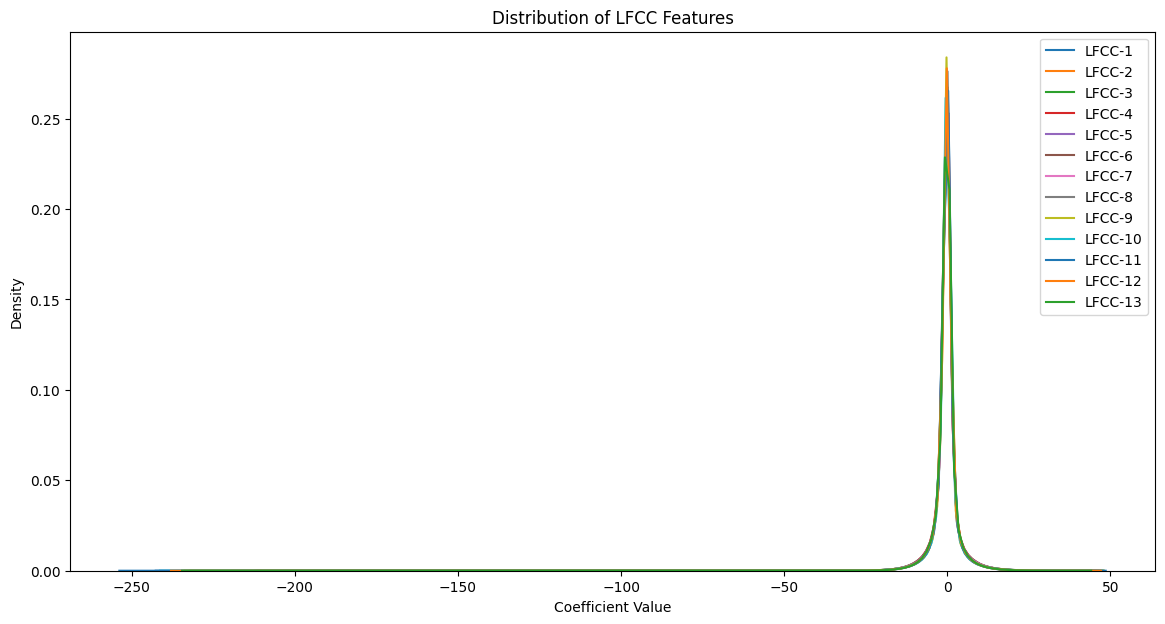

In [19]:
# Visualization Calls
plot_lfcc_distributions(aggregated_features)

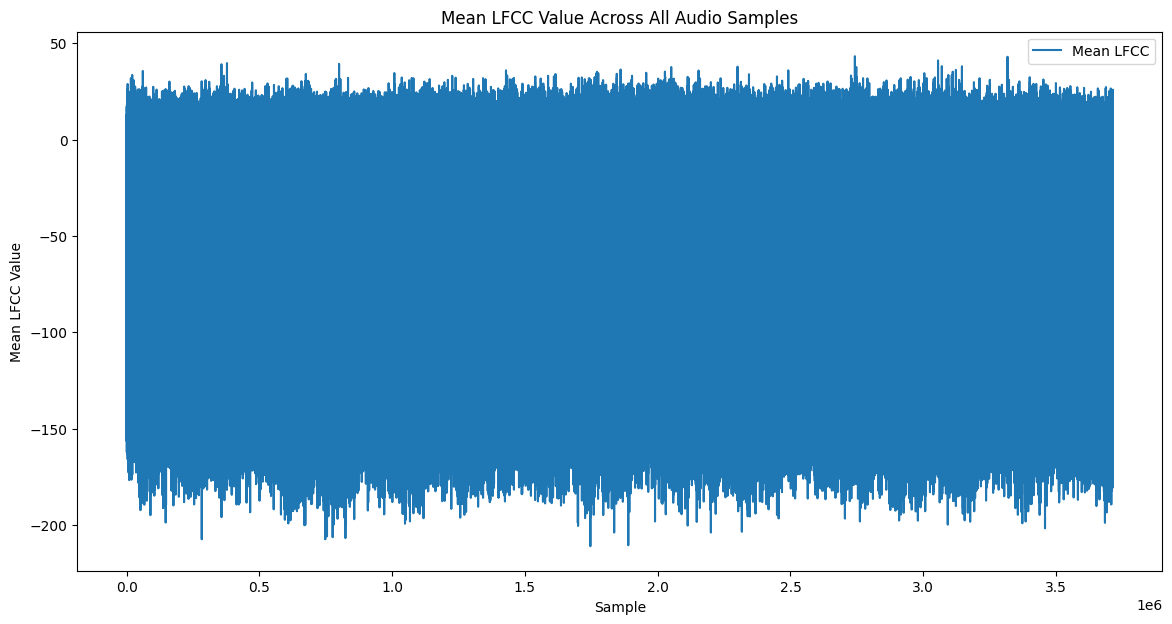

In [20]:
plot_mean_lfcc(aggregated_features)

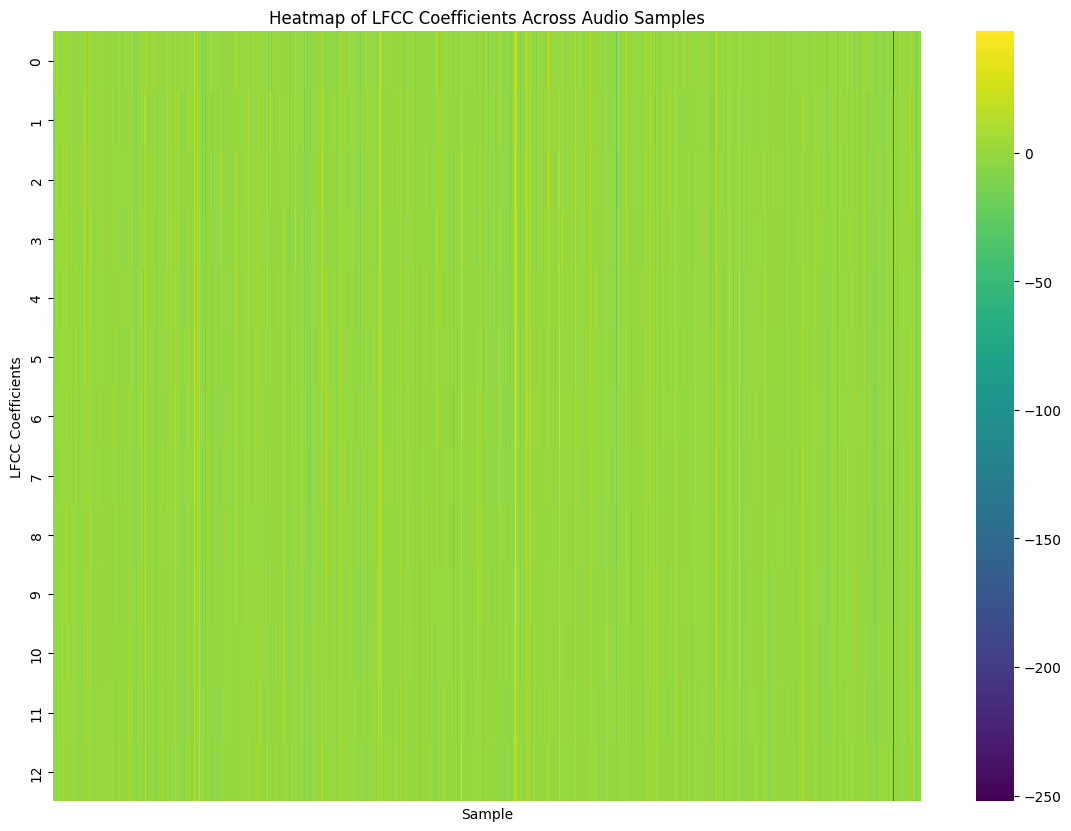

In [21]:
heatmap_lfcc_coefficients(aggregated_features)

In [24]:

# Assuming you have a way to separate real and synthetic samples along with labels
# real_features, synthetic_features, real_labels, synthetic_labels = your_data_separation_method(features)

# Step 4: Train GMM Models
real_gmm = train_gmm(real_features_flat)
#synthetic_gmm = train_gmm_models(synthetic_features_flat)

In [ ]:


# Evaluate Models
# Assuming you have split your dataset into training and testing
EER, eer_threshold = evaluate_gmm(real_gmm, synthetic_gmm, test_features, true_labels)

print(f"EER: {EER}, Threshold: {eer_threshold}")


In [ ]:
# Feature extraction (LFCC) for each audio
#ljdataset = load_ljspeech_dataset()
#ljdataset = extract_dataset(tar_path, extract_path)
real_features, _ = preprocess_and_extract_features(ljdataset)
#real_features = np.array([compute_lfcc(audio, samplerate=22050) for audio in audios])
#syndb = lad_synthetic_dataset()
#synthetic_features = preprocess_synthetic_features(syndb)

# Flatten features to fit GMM
real_features_flat = flatten_features(real_features)
synthetic_features_flat = flatten_features(synthetic_features)
#real_features_reshaped = np.vstack([f for f in real_features if f.size > 0])  # Ensure each feature array is not empty
#synthetic_features_reshaped = np.vstack([f for f in synthetic _features if f.size > 0])  # Ensure each feature array is not empty

# Split datasets into training and testing sets for evaluation
real_train, real_test = train_test_split(real_features_flat, test_size=0.2, random_state=42)
synthetic_train, synthetic_test = train_test_split(synthetic_features_flat, test_size=0.2, random_state=42)
    
# Train GMM models
real_gmm, synthetic_gmm = train_gmm_models(real_train, synthetic_train)

In [ ]:
import librosa
import numpy as np
from scipy.fftpack import dct
import soundfile as sf

def sigproc(signal, samplerate, preemph=0.97):
    """Apply pre-emphasis to the signal."""
    return np.append(signal[0], signal[1:] - preemph * signal[:-1])

def framesig(signal, frame_len, frame_step, winfunc=lambda x: np.ones((x,))):
    """Frame a signal into overlapping frames."""
    slen = len(signal)
    frame_len = int(round(frame_len))
    frame_step = int(round(frame_step))
    if slen <= frame_len:
        numframes = 1
    else:
        numframes = 1 + int(np.ceil((1.0 * slen - frame_len) / frame_step))
    padlen = int((numframes - 1) * frame_step + frame_len)
    zeros = np.zeros((padlen - slen,))
    padsignal = np.concatenate((signal, zeros))
    indices = np.tile(np.arange(0, frame_len), (numframes, 1)) + np.tile(np.arange(0, numframes * frame_step, frame_step), (frame_len, 1)).T
    frames = padsignal[indices.astype(np.int32, copy=False)]
    return frames * winfunc(frame_len)

def powspec(frames, NFFT):
    """Compute power spectrum of each frame."""
    if len(frames.shape) == 1:
        frames = frames[np.newaxis]
    return 1.0 / NFFT * np.square(np.abs(np.fft.rfft(frames, NFFT)))

# Assumes get_filterbanks and other necessary functions are defined or imported
# ...

audio_files = [os.path.join(dp, f) for dp, dn, filenames in os.walk(extract_path) for f in filenames if os.path.splitext(f)[1] == '.wav']
audio_samples = []

for file_path in tqdm(audio_files, desc="Processing audio files"):
    signal, sr = librosa.load(file_path, sr=16000)  # Resample to 16k
    lfcc_features = compute_lfcc(signal, samplerate=16000)
    audio_samples.append((file_path, lfcc_features))

print(f"Processed {len(audio_samples)} audio files.")


In [ ]:
# Evaluate models
real_predictions = predict(real_gmm, synthetic_gmm, real_test)
synthetic_predictions = predict(real_gmm, synthetic_gmm, synthetic_test)
    
# Combine real and synthetic predictions and true labels
predictions = np.concatenate((real_predictions, synthetic_predictions))
true_labels = np.concatenate((np.ones(len(real_test)), np.zeros(len(synthetic_test))))
    
# Print accuracy and classification report
print(f"Accuracy: {accuracy_score(true_labels, predictions)}")
print(classification_report(true_labels, predictions, target_names=['Synthetic', 'Real']))

In [ ]:
import numpy as np
import librosa
from sklearn.preprocessing import StandardScaler
from python_speech_features import logfbank  # Assuming use of python_speech_features for LFCC

def extract_lfcc(audio, sr=16000, n_filters=26, n_lfcc=20):
    """
    Extracts Linear Frequency Cepstral Coefficients (LFCC) from an audio signal.

    Parameters:
    - audio: The audio signal from which to extract features.
    - sr: The sample rate of the audio signal.
    - n_filters: The number of filters to use in the filterbank.
    - n_lfcc: The number of LFCCs to extract.

    Returns:
    - lfcc_features: An array of LFCC features averaged across time.
    """
    # Compute log filterbank energies.
    logfbank_features = logfbank(audio, samplerate=sr, nfilt=n_filters)
    
    # Compute DCT to get LFCCs, keep first 'n_lfcc' coefficients
    lfcc_features = np.fft.dct(logfbank_features, type=2, axis=1, norm='ortho')[:, :n_lfcc]
    return np.mean(lfcc_features, axis=0)

def extract_features(audios, sr=16000):
    """
    Wrapper function to load an audio file, pre-process it, and extract relevant features.

    Parameters:
    - audio_path: Path to the audio file.
    - sr: Sample rate to use for loading the audio.

    Returns:
    - features: A numpy array containing extracted features.
    """
    audio, sr = librosa.load(audios, sr=sr)
    lfcc = extract_lfcc(audio, sr)
    return lfcc

def scale_features(features):
    """
    Scales the features using StandardScaler.

    Parameters:
    - features: Numpy array of features to scale.

    Returns:
    - scaled_features: Scaled features.
    """
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(features.reshape(-1, 1))
    return scaled_features.flatten()


**Model Training**
Gaussian Mixture Model (GMM): Train two GMMs for each dataset - one for the real audio distribution (using the original LJSPEECH dataset) and one for the generated audio samples. This step involves:
    Calculating the likelihood ratio for classifying samples.
    Using MFCC and LFCC features as inputs.
    
RawNet2 Training (Optional): As an alternative to GMM, train a CNN-GRU hybrid model known as RawNet2 which directly extracts features from raw audio to create embeddings for classification.


In [ ]:
from sklearn.mixture import GaussianMixture
from sklearn.metrics import roc_curve
from scipy.optimize import brentq
from scipy.interpolate import interp1d

def train_gmm(features, n_components=16):
    """
    Train a Gaussian Mixture Model (GMM) on the provided features.

    Parameters:
    - features: Feature matrix for training the GMM.
    - n_components: Number of Gaussian components in the GMM.

    Returns:
    - gmm: Trained GMM object.
    """
    gmm = GaussianMixture(n_components=n_components, covariance_type='diag', max_iter=200, random_state=0)
    gmm.fit(features)
    return gmm

def preprocess_features(audios, sr=22050, n_lfcc=20):
    """
    Preprocess audio data and extract LFCC features.

    Parameters:
    - audios: List of audio waveforms.
    - sr: Sample rate of the audio data.
    - n_lfcc: Number of LFCC coefficients to extract.

    Returns:
    - features: Numpy array of extracted LFCC features for all audio samples.
    """
    features = []
    for audio in audios:
        lfcc = extract_lfcc(audio, sr=sr, n_lfcc=n_lfcc)
        features.append(lfcc)
    return np.array(features)

def compute_eer(y_true, y_scores):
    """
    Compute the Equal Error Rate (EER).

    Parameters:
    - y_true: Ground truth binary labels.
    - y_scores: Predicted scores or probabilities.

    Returns:
    - eer: Equal Error Rate.
    """
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    eer = brentq(lambda x: 1. - x - interp1d(fpr, tpr)(x), 0., 1.)
    return eer

from sklearn.metrics import roc_curve

def calculate_eer(y_true, y_scores):
    """
    Calculate the Equal Error Rate (EER).

    Args:
    - y_true: True binary labels in range {0, 1} or {-1, 1}.
    - y_scores: Target scores, can either be probability estimates of the positive class or confidence values.
    
    Returns:
    - EER value.
    """
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    fnr = 1 - tpr
    eer_threshold = thresholds[np.nanargmin(np.absolute((fnr - fpr)))]
    EER = fpr[np.nanargmin(np.absolute((fnr - fpr)))]
    
    return EER


def classify_samples(gmm_real, gmm_synthetic, features):
    """
    Classify samples using trained GMMs based on the log-likelihood ratio.

    Parameters:
    - gmm_real: GMM trained on real audio features.
    - gmm_synthetic: GMM trained on synthetic audio features.
    - features: Feature matrix of samples to classify.

    Returns:
    - scores: Log-likelihood ratio scores for the samples.
    """
    log_likelihood_real = gmm_real.score_samples(features)
    log_likelihood_synthetic = gmm_synthetic.score_samples(features)
    scores = log_likelihood_real - log_likelihood_synthetic
    return scores

In [ ]:
# Combine and split the dataset
features = np.vstack((features_real, features_synthetic))
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

# Train GMMs
gmm_real = train_gmm(X_train[y_train == 0], n_components=16)
gmm_synthetic = train_gmm(X_train[y_train == 1], n_components=16)

**Classifier Design**
Binary Classification: Design classifiers to distinguish between human and AI-generated voices. Use the GMM-based approach to calculate the likelihood of a sample being real or synthetic.

Evaluation Metrics: Utilize the Equal Error Rate (EER) as the primary metric for evaluating model performance.

In [ ]:
# Classify and evaluation
scores = classify_samples(gmm_real, gmm_synthetic, X_test)
eer = compute_eer(y_test, scores)
print(f"Equal Error Rate (EER): {eer:.2f}")

**Experiments and Evaluation**
Generalization Tests: Evaluate the classifier's performance on unseen data, such as JSUT and TTS datasets, to assess its ability to generalize.

Attribution Analysis: Implement attribution methods like BlurIG to understand which parts of the audio signal influence the prediction, focusing on specific features that distinguish between human and AI-generated voices.